In [13]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2024-05-15 20:53:24
# @Last Modified: 2024-05-15 21:00:21
# ------------------------------------------------------------------------------ #
# This notebook does the model comparison and creates the panel for fig. 2.
# it needs the idata traces from `bayesian_analysis.ipynb`
# Preprocessing / Setup in the first cell is the same in both notebooks.
# ------------------------------------------------------------------------------ #

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
extra_path = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = "/Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat"

# load our results from timescale fitting
df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity etc.
df = utl.load_metrics(
    df.reset_index(),
    data_dir,
    csvs=[
        # we need to combine data from different files, because we use spontaneous and natural movie stimuli
        "brain_observatory_1.1_analysis_metrics.csv",
        "functional_connectivity_analysis_metrics.csv",
    ],
    cols=["on_screen_rf"],
)
df = utl.add_structure_and_hierarchy_scores(df)

# pymc does not like bools:
log.info(f'invalid metric rows: {df["on_screen_rf"].isna().sum()}')
df["on_screen_rf"] = df["on_screen_rf"].astype("int")

# some further preprocessing is done in the model class
# see ana/bayesian_models.py
df

2024-05-17 07:19:17,918 | INFO     | notebook | <module> | project directory: /Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis
2024-05-17 07:19:22,882 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_1.1_analysis_metrics.csv
2024-05-17 07:19:23,129 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/functional_connectivity_analysis_metrics.csv
2024-05-17 07:19:23,130 | INFO     | its_utility | load_metrics | Column on_screen_rf found in multiple dataframes.
2024-05-17 07:19:23,131 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat/brain_observatory_1.1_analysis_

,unit_id,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,R_tot,tau_R,tau_single,tau_double,tau_R_details,tau_single_details,tau_double_details,on_screen_rf,structure_name,hierarchy_score
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.074624,0.058510,0.000054,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0,AM,0.441
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,0.112344,0.088701,2.302634,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0,AM,0.441
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,0.065517,0.059416,1.026283,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",1,AM,0.441
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,0.093197,0.116100,1.564297,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",1,AM,0.441
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.118505,0.064748,0.605686,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",1,AM,0.441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17944,950942400,spontaneous,771160300,null,VISal,SUCCESS,1797.115234,0.377828,/project.nst/neuroscience-raw/Allen/visual_cod...,679,...,0.079950,0.049446,0.257024,0.217925,"{'firing_rate': 0.36583331347267567, 'firing_r...","{'tau': 0.25702383931940154, 'mre': 0.98073454...","{'tau': 0.2179251442600049, 'mre': 0.977317546...",0,AL,0.152
17945,950944614,spontaneous,771160300,null,VISal,SUCCESS,1792.901855,0.377600,/project.nst/neuroscience-raw/Allen/visual_cod...,677,...,0.113514,0.042486,0.439570,0.057439,"{'firing_rate': 0.38629086027452963, 'firing_r...","{'tau': 0.4395698459887982, 'mre': 0.988689691...","{'tau': 0.05743850656844875, 'mre': 0.91663161...",0,AL,0.152
17946,950943984,spontaneous,771160300,null,VISal,SUCCESS,1773.977051,0.135289,/project.nst/neuroscience-raw/Allen/visual_cod...,240,...,0.036887,0.043392,0.170987,0.170986,"{'firing_rate': 0.13628681470096451, 'firing_r...","{'tau': 0.1709865057191234, 'mre': 0.971181338...","{'tau': 0.17098641292634262, 'mre': 0.97118132...",0,AL,0.152
17947,950942680,spontaneous,771160300,null,VISal,SUCCESS,1801.591797,12.195324,/project.nst/neuroscience-raw/Allen/visual_cod...,21971,...,0.050547,0.008184,0.081918,0.068260,"{'firing_rate': 12.154834329411557, 'firing_ra...","{'tau': 0.08191797577480081, 'mre': 0.94078874...","{'tau': 0.06826005692776223, 'mre': 0.92936912...",1,AL,0.152


In [14]:
# Lets start with a bit of exploration:
measure = "tau_R"
# linear model
idata_lm = az.from_netcdf(f"{data_dir}/lm_{measure}_nat_mov.nc")
# structure group model
idata_sgm = az.from_netcdf(f"{data_dir}/sgm_{measure}_nat_mov.nc")
idata_sgm

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

In [45]:
idata_lm

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

In [16]:
lm = bm.LinearModel(df.query("stimulus == 'natural_movie_three'"), measure)
sgm = bm.StructureGroupModel(df.query("stimulus == 'natural_movie_three'"), measure)

pm.compute_log_likelihood(
    idata_lm,
    model=lm,
    extend_inferencedata=True,
)
pm.compute_log_likelihood(
    idata_sgm,
    model=sgm,
    extend_inferencedata=True,
)
comparison = az.compare(
    {"linear model": idata_lm, "structure groups": idata_sgm},
)
comparison

Output()

Output()

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
structure groups,0,-8280.903231,76.219932,0.000000,0.901655,83.587912,0.000000,False,log
linear model,1,-8558.818998,47.869995,277.915767,0.098345,76.938272,26.880775,False,log


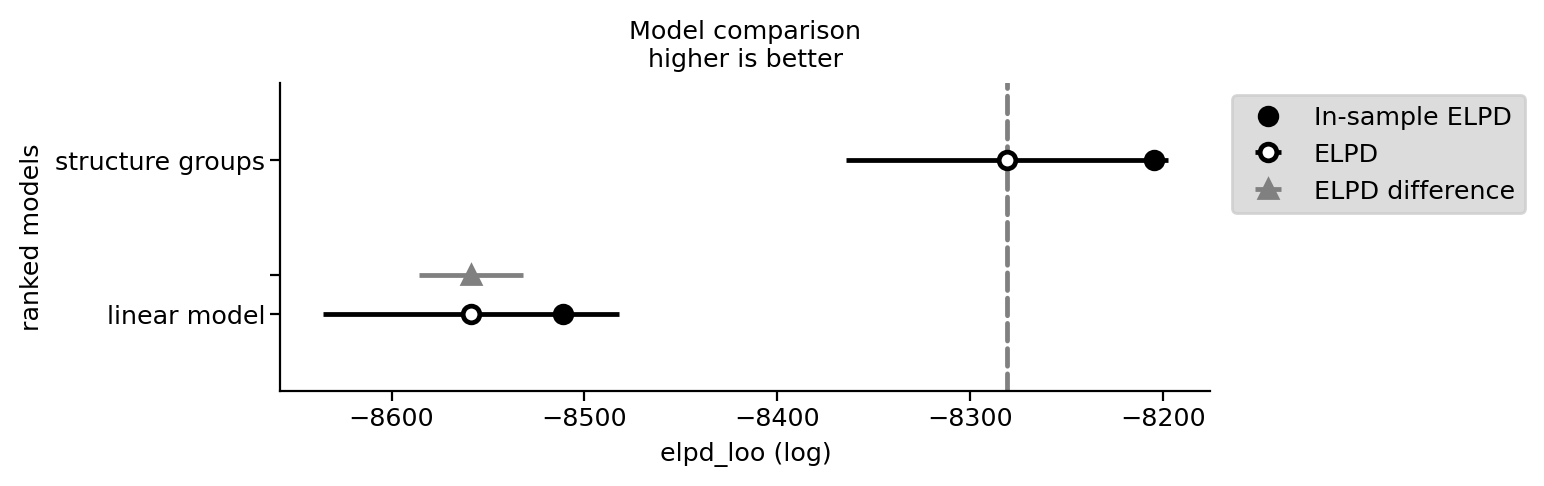

In [17]:
az.plot_compare(comparison, insample_dev=True, plot_ic_diff=True, plot_standard_error=True);

In [18]:
comparison["elpd_loo"]

structure groups   -8280.903231
linear model       -8558.818998
Name: elpd_loo, dtype: float64

In [19]:
loo_lm = az.loo(idata_lm, pointwise=True)
loo_sgm = az.loo(idata_sgm, pointwise=True)

In [29]:
obs = 'loo_i'
print(f"shape: {loo_lm[obs].shape}")
print(f"lm: {np.sum(loo_lm[obs]).values}")
print(f"sgm: {np.sum(loo_sgm[obs]).values}")
diff = loo_lm[obs] - loo_sgm[obs]
print(f"diff {np.sum(diff).values}")
print(f"se: {np.sqrt(len(diff) * np.var(diff)).values}")

shape: (6256,)
lm: -8558.81899810318
sgm: -8280.90323121093
diff -277.9157668922502
se: 26.880775172556003


In [28]:
len(loo_sgm['loo_i'].values)

6256

In [26]:
np.sum(loo_sgm['loo_i'].values - loo_lm['loo_i'].values)

277.9157668922502

In [34]:
obs = 'elpd_loo'
print(f"shape: {loo_lm[obs].shape}")
print(f"lm: {np.sum(loo_lm[obs])}")
print(f"sgm: {np.sum(loo_sgm[obs])}")
diff = loo_lm[obs] - loo_sgm[obs]
print(f"diff {np.mean(diff)}")

shape: ()
lm: -21644.901937838375
sgm: -21349.392344066167
diff -295.50959377220715


In [2]:
from itertools import product
from tqdm.notebook import tqdm

models = ['sgm', 'lm']
datasets = ["allen_fc", "allen_bo"]

defined_measures = ["R_tot", "tau_R", "tau_double"]
defined_stimuli = ["nat_mov", "spontaneous"]

combinations = list(product(defined_measures, defined_stimuli, models))
loos = dict()

for dset, meas, stim, model in tqdm(combinations):
    try:
        idata = az.from_netcdf(f"/scratch.local/pspitzner/information_timescales/paper_plots/data/prepped/{dset}_{meas}_{stim}_{model}.h5")
        _ = az.loo(idata, pointwise=True)
        loos[f"{dset}_{meas}_{stim}_{model}"] = az.loo(idata, pointwise=True)
    except:
        # allen_bo does not have a spontaneous stimulus
        pass

dict_keys(['structural_groups', 'hierarchy_score'])

['tau_C', 'tau_R', 'R_tot']


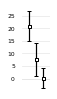

In [4]:

# FPS: The other panesl are quite big and we downscale them to ~60%.
# Here I used native / real-life units (100%), with font sizes ~8pt and 6pt.
fig, ax = plt.subplots(figsize=(4,3))

matplotlib.rcParams["savefig.facecolor"] = (0.0, 0.0, 0.0, 0.0)  # transparent figure bg
matplotlib.rcParams["axes.facecolor"] = (1.0, 0.0, 0.0, 0.0)
matplotlib.rcParams["xtick.labelsize"]= 6
matplotlib.rcParams["ytick.labelsize"]= 6

dset = "allen_fc"
# dset = "allen_bo"
# stim = "spontaneous"
stim = "movie"
for mdx, meas in enumerate(defined_measures):
    if dset == "allen_bo" and stim == "spontaneous":
        raise ValueError("allen_bo does not have spontaneous stimulus")
    # this is the same what arviz.compare does
    # I decided to not use az.compare because it ranks the models, but we always want
    # to have "structure_groups - linear_model".
    diff = (
        loos[f"{dset}_{meas}_{stim}_lm"]["loo_i"]
        - loos[f"{dset}_{meas}_{stim}_sgm"]["loo_i"]
    )
    ax.errorbar(
        x=mdx + 1,
        y=np.sum(diff),
        yerr=np.sqrt(len(diff) * np.var(diff)),
        label=f"{meas}",
        fmt = "s",
        # markeredgewidth = 0.0,
        markersize = 3.0,
        markerfacecolor = 'white',
        ecolor = 'black',
        color = "black",
        elinewidth = 1.2,
        capsize = 2,
        clip_on=False,
    )

ax.set_xticks([])
# ax.set_ylim(-28, 5)
# yticks = [-25, -20, -15, -10, -5, 0]
yticks = [25, 20, 15, 10, 5, 0]
ax.set_yticks(yticks)
for y in yticks:
    ax.axhline(y, ls="-", lw=1.0 if y == 0 else 0.7, zorder=0, color="#E6E6E6")
ax.set_xlim(0, 4)
sns.despine(ax=ax, trim=False, bottom=True)
# ax.set_ylabel("ELPD difference")
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
print(defined_measures)

set_size(ax, w=1.0, h=3.0, b=0.1, l=0.7, t=0.1)
ax.get_figure().savefig(f"../img/model_comparison_{dset}_{stim}_all_measures.pdf")